In [505]:
from brian2 import *
import pandas as pd

from scipy.stats import pearsonr
import numpy as np

In [507]:
start_scope()

In [508]:
# Parameters
simulation_duration = 1800 * second

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
tauc = 1000*ms
taud = 200*ms
taus = 1*ms

In [509]:
df = pd.read_csv("../data/spike_matrix.csv")  


spike_times = []
for neuron_idx in range(1, 51):  # kolumny 1–50
    spikes = df[df.iloc[:, neuron_idx] == 1]
    times = spikes.iloc[:, 0].values  # kolumna 0 = czas
    spike_times.extend(zip([neuron_idx - 1]*len(times), times))


spike_indices = np.array([i for i, _ in spike_times])
spike_times_s = np.array([t for _, t in spike_times]) * second 


In [528]:
spike_indices[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [518]:
print(f"Pierwsze 10 czasów spików: {spike_times[:10]}")
print(f"Pierwsze 10 indeksów neuronów: {spike_indices[:10]}")


Pierwsze 10 czasów spików: [(0, np.float64(2.368)), (0, np.float64(24.958)), (0, np.float64(51.219)), (0, np.float64(90.606)), (0, np.float64(127.549)), (0, np.float64(161.729)), (0, np.float64(172.181)), (0, np.float64(216.887)), (0, np.float64(233.589)), (0, np.float64(260.353))]
Pierwsze 10 indeksów neuronów: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
time_column = df.iloc[:, 0].values * second  
spike_data = df.iloc[:, 1:].values 

In [ ]:
for neuron_id in range(spike_data.shape[1]): 
    times = time_column[spike_data[:, neuron_id] == 1] 
    spike_times.extend(times)
    spike_indices.extend([neuron_id] * len(times))


In [ ]:
spike_input = SpikeGeneratorGroup(50, spike_indices, spike_times)


In [521]:
print(f"SpikeGeneratorGroup: {spike_input}")
print(f"Liczba neuronów: {spike_input.N}") 


SpikeGeneratorGroup: SpikeGeneratorGroup(50, indices=<length 121767 array>, times=<length 121767 array>)
Liczba neuronów: 50


In [511]:
spike_input = SpikeGeneratorGroup(50, spike_indices, spike_times_s)

In [512]:
neurons = NeuronGroup(2, '''dv/dt = (ge * (Ee-v) + El - v) / taum : volt
                            dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='euler')
neurons.v = vr
neurons_monitor = SpikeMonitor(neurons)

synapse = Synapses(spike_input, neurons,
                   model='''s: volt''',
                   on_pre='v += s')
synapse.connect(i=[0, 1], j=[0, 1])
synapse.s = 100. * mV

In [522]:
neurons_indices, neurons_times = neurons_monitor.it

print(f"Pierwsze 10 czasów spików neuronów: {neurons_times[:10]}")
print(f"Pierwsze 10 indeksów neuronów: {neurons_indices[:10]}")


Pierwsze 10 czasów spików neuronów: [2.3681 2.6081 2.6141 2.6241 3.1271 3.2331 4.1921 4.2191 4.2321 4.2461] s
Pierwsze 10 indeksów neuronów: [0 1 1 1 1 1 1 1 1 1]


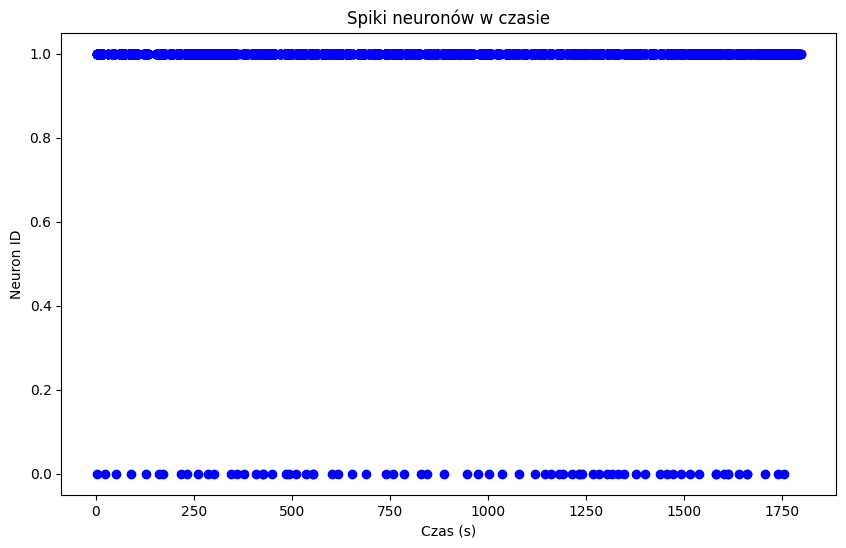

In [523]:
plt.figure(figsize=(10, 6))
plt.plot(neurons_times, neurons_indices, 'ob') 
plt.title('Spiki neuronów w czasie')
plt.xlabel('Czas (s)')
plt.ylabel('Neuron ID')
plt.show()


In [513]:
## STDP section
synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )

In [514]:
synapse_stdp.connect(i=0, j=1)
synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0
synapse_stdp_monitor = StateMonitor(synapse_stdp, ['s', 'c', 'd'], record=[0])

In [515]:
# Simulation
## Classical STDP
synapse_stdp.mode = 0
run(simulation_duration)

WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/6y/g2p2w1qs6zs509fmkdpp5b4m0000gn/T/ipykernel_36424/2973150723.py', line 35, in <module>
    output_group = NeuronGroup( [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File '/var/folders/6y/g2p2w1qs6zs509fmkdpp5b4m0000gn/T/ipykernel_36424/2973150723.py', line 74, in <module>
    syn = Synapses(input_group, output_group, model=eqs, on_pre=on_pre, on_post=on_post) [brian2.core.base.unused_brian_object]


Siła synapsy: [100. 100.] mV


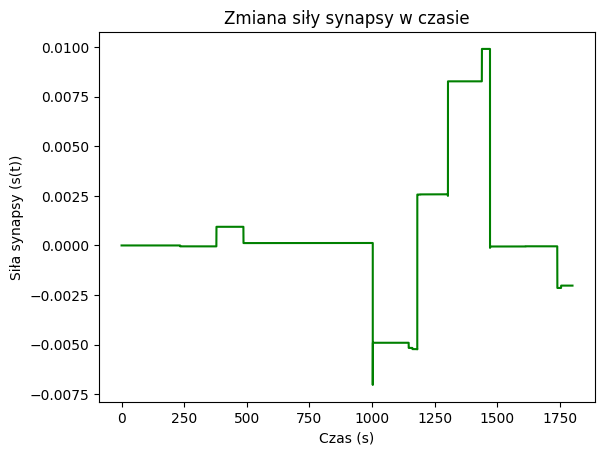

In [524]:
print(f"Siła synapsy: {synapse.s[:10]}") 

plt.plot(synapse_stdp_monitor.t / second, synapse_stdp_monitor.s.T / gmax, 'g-')
plt.title('Zmiana siły synapsy w czasie')
plt.xlabel('Czas (s)')
plt.ylabel('Siła synapsy (s(t))')
plt.show()


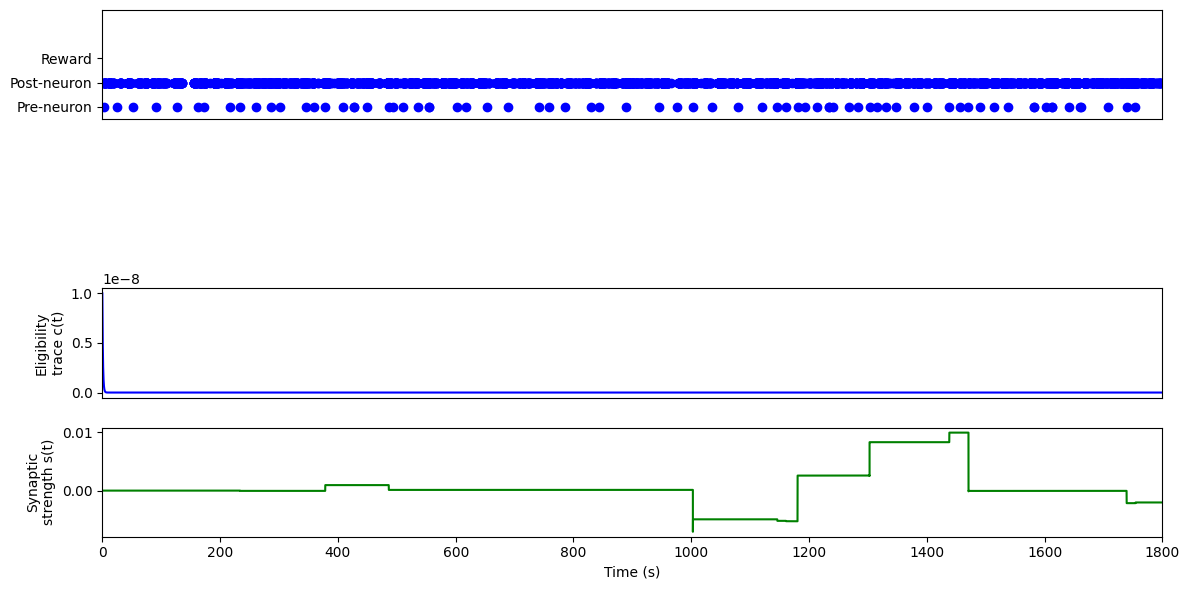

In [516]:
# Visualisation
neurons_indices, neurons_times = neurons_monitor.it
figure(figsize=(12, 6))
subplot(411)
plot(neurons_times, neurons_indices, 'ob')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()

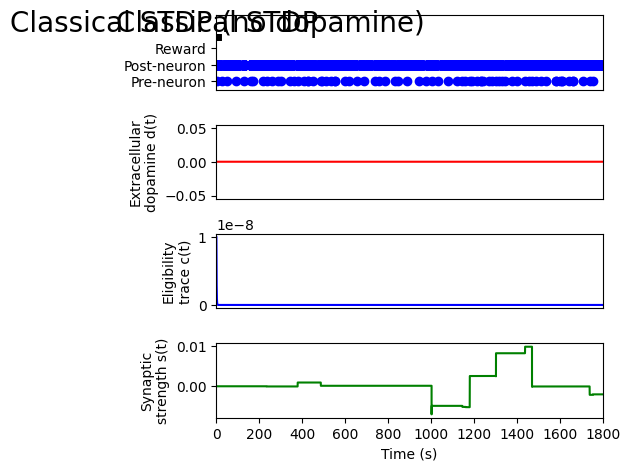

In [517]:
# 1. Wykres spików neuronów
subplot(411)
plot([0.05, 2.95], [2.7, 2.7], linewidth=5, color='k')  # Granica dla klasycznego STDP
text(1.5, 3, 'Classical STDP', horizontalalignment='center', fontsize=20)
plot([3.05, 5.95], [2.7, 2.7], linewidth=5, color='k')  # Granica dla STDP bez dopaminy
text(4.5, 3, 'Classical STDP (no dopamine)', horizontalalignment='center', fontsize=20)

plot(neurons_times, neurons_indices, 'ob') 

xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])  
xticks([])

# 2. Wykres STDP (zmiana siły synapsy)
subplot(412)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular\ndopamine d(t)')  
xticks([])

subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility\ntrace c(t)')
xticks([])

subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')
tight_layout()
show()

In [452]:
# ======= PARAMETRY =======
bin_size = 1 * ms         # czas trwania jednego kroku
similarity_threshold = 0.8  # próg do nagrody

# ======= DANE MEA =======

n_neurons = df.shape[1] - 1
simulation_time = df.iloc[:, 0].max() * ms
window_ms = int(bin_size / ms)
total_steps = int(simulation_time / bin_size)

# ======= SPIKEGENERATORGROUP =======
dt = 0.1 * ms  # krok symulacji
df.iloc[:, 0] = (np.round(df.iloc[:, 0] / (dt/ms)) * (dt/ms))  # zaokrąglenie czasu

spike_times = []
spike_indices = []

for neuron in range(n_neurons):
    times = df[df.iloc[:, neuron + 1] == 1].iloc[:, 0].values
    spike_times.extend(times)
    spike_indices.extend([neuron] * len(times))

# df z indeksami i czasami
spike_df = pd.DataFrame({'neuron': spike_indices, 'time': spike_times})
spike_df.drop_duplicates(subset=['neuron', 'time'], inplace=True)  # usunięcie powtórzeń

# SpikeGeneratorGroup
input_group = SpikeGeneratorGroup(
    n_neurons,
    indices=spike_df['neuron'].values,
    times=spike_df['time'].values * ms
)
# ======= WARSTWA WYJŚCIOWA =======
output_group = NeuronGroup(
    n_neurons,
    '''
    dv/dt = -v / (20*ms) : 1
    ''',
    threshold='v > 1',
    reset='v = 0',
    method='exact'
)

# ======= SYNAPSY STDP + NAGRODA =======
taupre = taupost = 20 * ms
gmax = 0.01
dApre = 0.01
dApost = -dApre * 1.05

eqs = '''
w : 1
dApre/dt = -Apre / taupre : 1 (event-driven)
dApost/dt = -Apost / taupost : 1 (event-driven)
c : 1
dopamine : 1 (shared)
'''

on_pre = '''
Apre += dApre
c += Apost
v_post += w
'''

on_post = '''
Apost += dApost
c += Apre
'''

reward_eq = '''
w = clip(w + dopamine * c, 0, gmax)
'''

syn = Synapses(input_group, output_group, model=eqs, on_pre=on_pre, on_post=on_post)
syn.connect()
syn.w = 'rand() * gmax'
syn.dopamine = 0
syn.run_regularly(reward_eq, dt=10*ms)

# ======= MONITORY =======
mon = SpikeMonitor(output_group)

# ======= SIEĆ =======
net = Network(collect())
net.add(input_group, output_group, syn, mon)

# ======= PRZYGOTOWANIE DANYCH BINARNYCH =======
binary_target = np.zeros((total_steps, n_neurons))
for i in range(n_neurons):
    times = df[df.iloc[:, i + 1] == 1].iloc[:, 0].values
    for t in times:
        idx = int(t // window_ms)
        if idx < total_steps:
            binary_target[idx, i] = 1

# ======= TRENING Z NAGRODĄ =======
results = []

for step in range(total_steps):
    mon = SpikeMonitor(output_group)
    net.add(mon)

    net.run(bin_size)

    spikes = (mon.count > 0).astype(int)
    target = binary_target[step]
    similarity = np.mean(spikes == target)
    reward = 1 if similarity > similarity_threshold else 0
    syn.dopamine = reward
    results.append(spikes)

    net.remove(mon)


# ======= ZAPIS WYNIKU =======
output_df = pd.DataFrame(results, columns=[f'n_{i}' for i in range(n_neurons)])
output_df.insert(0, 't_bin', [i * window_ms for i in range(total_steps)])
output_df.to_csv('generated_spikes.csv', index=False)


WARNING    't' is an internal variable of group 'synapses_9', but also exists in the run namespace with the value np.float64(1800.0). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [467]:
output_df
df

,Time,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch1,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch10,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch11,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch12,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch13,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch14,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch2,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch202,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch205,...,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch262,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch263,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch264,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch3,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch4,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch5,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch6,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch7,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch8,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch9
0,0.000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799996,1799.996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799997,1799.997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799998,1799.998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799999,1799.999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [468]:
# Oryginalne dane MEA 
mea_df = df
# Wygenerowane dane z modelu
generated_df = output_df

In [469]:
mea_df

,Time,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch1,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch10,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch11,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch12,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch13,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch14,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch2,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch202,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch205,...,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch262,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch263,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch264,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch3,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch4,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch5,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch6,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch7,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch8,V2022_01_20T15_00_00vHip1_big_filtered_sorted_Ch9
0,0.000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799996,1799.996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799997,1799.997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799998,1799.998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799999,1799.999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [484]:
generated_df

,t_bin,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,...,n_40,n_41,n_42,n_43,n_44,n_45,n_46,n_47,n_48,n_49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,1,0
4,4,1,0,1,1,1,0,1,0,0,...,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,1795,1,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1796,1796,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,1,1,0,0,0
1797,1797,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1798,1798,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,1


In [471]:
min_len = min(len(mea_df), len(generated_df))
mea_array = mea_df.iloc[:min_len, 1:].to_numpy()
gen_array = generated_df.iloc[:min_len, 1:].to_numpy()


In [494]:
mea_array.shape[0]

1800

In [501]:
row_sums = mea_array.sum(axis=1)
row_sums

array([0, 0, 0, ..., 0, 0, 0])

In [502]:
row_sums = gen_array.sum(axis=1)
row_sums

array([ 0,  0,  0, ...,  1,  6, 22])

In [ ]:
gen_array

In [492]:
np.mean(mea_array == gen_array, axis=1)

array([1.  , 1.  , 1.  , ..., 0.98, 0.88, 0.56])

In [472]:
from sklearn.metrics import hamming_loss, accuracy_score

similarities = np.mean(mea_array == gen_array, axis=1)
avg_hamming = np.mean(similarities)
print("Średnia Hamming similarity:", avg_hamming)

acc = accuracy_score(mea_array.flatten(), gen_array.flatten())
print("Dokładność ogólna (accuracy):", acc)


Średnia Hamming similarity: 0.7916555555555556
Dokładność ogólna (accuracy): 0.7916555555555556


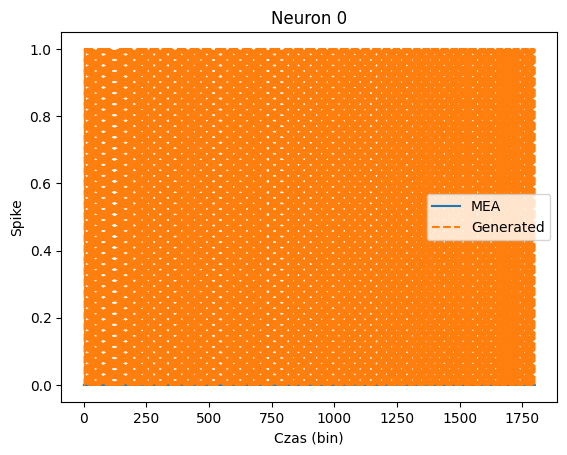

In [473]:
neuron_id = 0
plt.plot(mea_array[:, neuron_id], label='MEA')
plt.plot(gen_array[:, neuron_id], label='Generated', linestyle='--')
plt.title(f'Neuron {neuron_id}')
plt.xlabel('Czas (bin)')
plt.ylabel('Spike')
plt.legend()
plt.show()


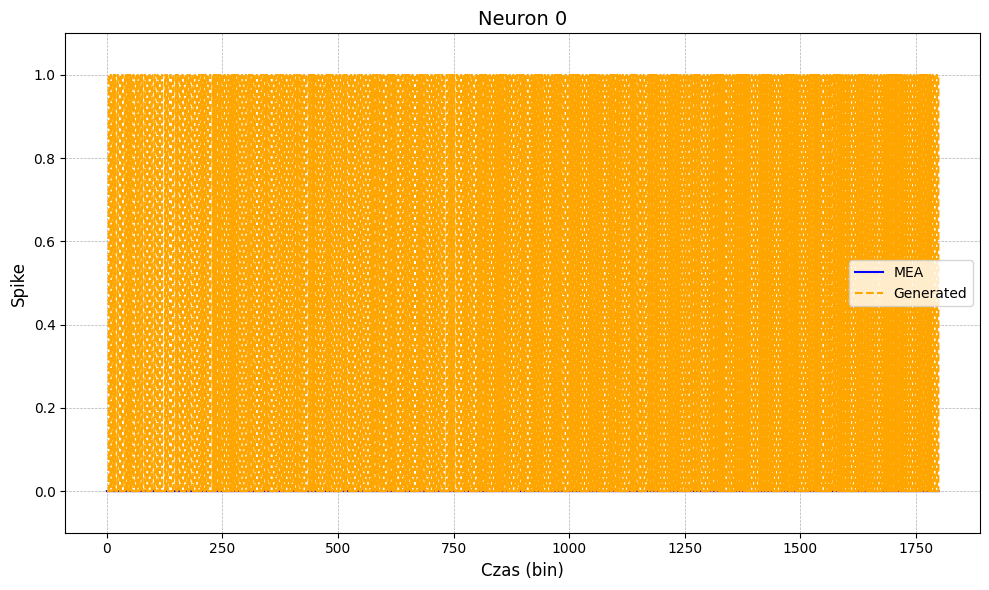

In [476]:
plt.figure(figsize=(10, 6))
plt.step(np.arange(len(mea_array[:, neuron_id])), mea_array[:, neuron_id], label='MEA', color='blue', where='post')
plt.step(np.arange(len(gen_array[:, neuron_id])), gen_array[:, neuron_id], label='Generated', linestyle='--', color='orange', where='post')


plt.title(f'Neuron {neuron_id}', fontsize=14)
plt.xlabel('Czas (bin)', fontsize=12)
plt.ylabel('Spike', fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.tight_layout() 
plt.show()


In [483]:
gen_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 0, 0]])

In [506]:
pearson_corrs = []


for i in range(mea_array.shape[1]): 
    # Korelacja między odpowiednimi kolumnami
    corr, p_value = pearsonr(mea_array[:, i], gen_array[:, i])
    pearson_corrs.append((i, corr, p_value))  

for i, corr, p_value in pearson_corrs:
    print(f"Neuron {i}: r = {corr:.3f}, p = {p_value:.3f}")

WARNING    /var/folders/6y/g2p2w1qs6zs509fmkdpp5b4m0000gn/T/ipykernel_36424/3867781385.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(mea_array[:, i], gen_array[:, i])
 [py.warnings]


Neuron 0: r = nan, p = nan
Neuron 1: r = nan, p = nan
Neuron 2: r = -0.018, p = 0.442
Neuron 3: r = -0.011, p = 0.633
Neuron 4: r = 0.007, p = 0.759
Neuron 5: r = nan, p = nan
Neuron 6: r = nan, p = nan
Neuron 7: r = -0.019, p = 0.420
Neuron 8: r = nan, p = nan
Neuron 9: r = nan, p = nan
Neuron 10: r = nan, p = nan
Neuron 11: r = nan, p = nan
Neuron 12: r = -0.003, p = 0.905
Neuron 13: r = 0.013, p = 0.576
Neuron 14: r = -0.006, p = 0.800
Neuron 15: r = -0.016, p = 0.490
Neuron 16: r = nan, p = nan
Neuron 17: r = -0.019, p = 0.414
Neuron 18: r = nan, p = nan
Neuron 19: r = 0.028, p = 0.239
Neuron 20: r = -0.016, p = 0.486
Neuron 21: r = 0.016, p = 0.498
Neuron 22: r = nan, p = nan
Neuron 23: r = 0.007, p = 0.780
Neuron 24: r = 0.052, p = 0.029
Neuron 25: r = nan, p = nan
Neuron 26: r = 0.004, p = 0.856
Neuron 27: r = nan, p = nan
Neuron 28: r = -0.016, p = 0.490
Neuron 29: r = nan, p = nan
Neuron 30: r = nan, p = nan
Neuron 31: r = nan, p = nan
Neuron 32: r = -0.012, p = 0.626
Neuron 3